# Homework 2

In [71]:
using LinearAlgebra
using Plots


## Mc-Call Job Search Model with Separation

We consider here a very simple job-search model, with separation. Our goal consists in solving this model using a policy iteration algorithm. Some background on the McCall and numerical ideas are discussed on the [QuantEcon](`https://julia.quantecon.org/mccall_model.html`) website.

There is a single worker who can be either employed ("e") or unemployed ("u") in any period.

When unemployed, the jobless worker receives unemployment benefits $c_t=\alpha>0$ in every period as long as he stays unemployed. He also receives a salary offer $w_t$ which is drawn from a discrete i.i.d. distribution and takes values $w_1, ..., w_K$ with probabilities $p_1, ... p_K$ respectively.

When an unemployed worker accepts an offer in period $t$, he gets the salary $w_t$ and becomes employed. He then keeps his salary $w_t$ as long as he stays employed (for $s\geq t$, $c_s=w_t$ if $t$ is the date at which worker got the current job); in each period he has a probability $\lambda$ of becoming unemployed in the next period and remains employed otherwise.

When a worker receives a given amount $x$ his perceived utility is $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma>1.0$. A worker discounts the future at a rate $\beta \in [0,1[$. As a result, in any period $t_0$ workers seek to maximize $\sum_{t\geq t_0}^{\infty} U(c_t)$.


__Define a parameter type `Parameter`, with fields $\alpha$, $\beta$, $\gamma$, $K$, $\sigma$, $\lambda$. Create a parameter variable $\omega$ with $\alpha=0.5$, $\beta=0.96$, $\gamma=4$, $K=10$, $\sigma=0.6$, $\lambda=0.015$__

In [154]:
struct Parameter
    α::Float64
    β::Float64
    γ::Int64    
    K::Int
    σ::Float64
    λ::Float64 
end

In [155]:
ω = Parameter(0.5,0.96,4,10,0.6,0.015)

Parameter(0.5, 0.96, 4, 10, 0.6, 0.015)

__What is the uniform distribution, whose mean is 1 and standard deviation is $\sigma$? Write a function `discrete_uniform(σ::Float64, K::Int64)::Tuple{Vector{Float64} Vector{Float64}}` to discretize it, using $K$ points. The function should return two vectors `w` and `p` of floats of the same size `K`. Check the results satisfy the right conditions (uniformity, standard deviation).__

In [156]:
function discrete_uniform(σ::Float64, K::Int64)::Tuple{Vector{Float64}, Vector{Float64}}
    w = collect(LinRange(1-sqrt(3)*σ, 1+sqrt(3)*σ, K)) # uniform distribution with mean=1, sd = σ
    p = [1/K for i = 1:K] 
    return w,p
end

discrete_uniform (generic function with 1 method)

###### We check that the results satisfy the right conditions in terms of uniformity and standard deviation

In [157]:
w, p = discrete_uniform(ω.σ, ω.K)

([-0.03923048454132627, 0.19170962313452397, 0.4226497308103742, 0.6535898384862244, 0.8845299461620747, 1.115470053837925, 1.3464101615137751, 1.5773502691896255, 1.8082903768654757, 2.039230484541326], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [158]:
mean = dot(w,p)

0.9999999999999998

In [159]:
σ = dot((w-ones(ω.K)).^2 ,p)^0.5

0.6633249580710798


The optimal decision of a worker is characterized by two value functions: $V^E(w)$ is the value of being employed at wage $w$ and $V^U(w)$ the value of being unemployed, while receiving job offer $w_t$. In Julia, both $V^U$ and $V^E$ will be represented by arrays `V_U` and `V_E` of size `K`.

A policy `g(w)` is a binary choice in the unemployed state: accept or reject an offer $w_t$. It will then naturally be represented by a boolean array (type `zeros(Bool, K)` to initialize one).

__Given a policy $g$, write down the recursive equations which defines the corresponding value functions $V^{U,g}(w)$ and $V^{E,g}(w)$.__

$$V^{E,g}(w) = U(w) + \beta \left( (1-\lambda)V^{E,g}(w) + \lambda E_w V^{U,g}(w) \right)$$

if $g(w) = 0$
$$V^{U,g}(w) = U(\alpha) + \beta E_{W'}\left[ V^{U,g}(w') \right]$$

if $g(w) = 1$
$$V^{U,g}(w) = U(w) + \beta V^{E,g}(w)$$

For the computation of the expectation, 

$$E_w[V^U(w)] = \sum_{i=1}^K p_{i}V^U(w_i)$$


__Write a function which takes a guess $V^{U,g}(w)$ and $V^{E,g}(w)$ and a policy function $g$ as arguments (and other model parameters) and updates the values, according to the updating equations. This function could have signature `value_update(V_U::Vector{Float64}, V_E::Vector{Float64}, g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64})::Vector{Float64}` where the returned vector has the same size as the supplied ones.__

In [160]:
function U(x::Float64; γ = ω.γ)
    return (x^(1-γ)) / (1-γ)
end

U (generic function with 1 method)

In [161]:
function value_update(V_U::Vector{Float64}, V_E::Vector{Float64}, g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, 
    p::Vector{Float64})::Vector{Float64}
    
    new_V_U, new_V_E = zeros(ω.K), zeros(ω.K)
    
    for k = 1:ω.K
        accept = g[ω.k]
        if accept
            w = w[k]
            new_V_U[k] = U(w) + ω.β * V_E[w]
        else 
            new_V_U[k] = U(w) + ω.β * sum( U.(w).*p )
        end
    end
    for k = 1:ω.K
        new_V_E[k] = U(w) + ω.β * ω.λ * V_E[k] +  ω.β * (1 - ω.λ) * sum( U.(w).*p )
    end
    return new_V_U, new_V_E
end

value_update (generic function with 1 method)


__Write a function `eval_policy(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Tuple{Vector{Float64}, Vector{Float64}}` which iterates on `value_update` find the values that satisfy the evaluation equations for policy `g`.__


In [162]:
function eval_policy(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, 
        η::Float64)::Tuple{Vector{Float64}, Vector{Float64}}
    
    V_U_0, V_E_0 = zeros(ω.K), zeros(ω.K)
    for k = 1:10000
        V_U, V_E = value_update(V_U_0, V_E_0, g, ω, w, p)
        err = abs(V_U .- V_U_0) + abs(V_E_0 .- V_E)
        if err < η
            break
        end 
        V_U_0, V_E_0 = V_U, V_E
    end
    return V_U, V_E
end  

eval_policy (generic function with 1 method)


__Write a function `improve_policy(g::Vector{Bool}, V_U::Vector{Bool}, V_E::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Vector{Float64}` which returns the improved policy given guesses for the value function(s) at for $t+1$.__

In [163]:
function improve_policy(g::Vector{Bool}, V_U, V_E, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)
    V_U_1, V_E_1 = eval_policy(g, ω, w, p, η)

    
end

improve_policy (generic function with 1 method)

__Implement the policy function algorithm. Print the successive approximation errors and comment on the convergence speed.__


## Neoclassical growth model (2)

We consider here, another deterministic version of the neoclassical growth model, but propose a slightly different solution method.

A representative agent uses capital $k_t$ to produce $y_t$ using the following production function:

$$y_t = k_t^{\alpha}$$

He chooses to consume an amount $c_t \in ]0, y_t]$ and invests what remains:

$$i_t = y_t - c_t$$.

He accumulates capital $k_t$ according to:

$$k_{t+1} = \left( 1-\delta \right) k_{t} + i_{t}$$

where $\delta$ is the depreciation rate and $i_t$ is the amount invested.

The goal of the representative agent is to maximize:

$$\sum_{t\geq 0} \beta^t U(c_t)$$

where $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ and $\beta<1$ is the discount factor.

Since the problem is time homogenous, the value function depends on available capital only and satisfies the following Bellman equation:

$$V\left(\underbrace{k}_{k_t}\right) = \max_{c\in[0,1[} U(c) + \beta V\left(\underbrace{(1-\delta)k + \underbrace{(k^{\alpha}-c)}_{y_{t+1}}}_{k_{t+1}}\right)$$

Our goal is to obtain a smooth approximation of $k$ and $V$ by using interpolations techniques.

For this model, using the dynamic first-order conditions, one can show the deterministic steady-state of the model satisfies $1=\beta \left( (1-\delta) + \alpha k^{\alpha -1} \right)$. 

__Create a suitable Parameter type to hold the parameters. Write a function `steady_state(p::Parameter)` to compute the steady-state capital `kbar` and the corresponding steady-state consumption `cbar`__ 


In [197]:
struct Parameter_1
    α::Float64
    β::Float64
    γ::Int64
    δ::Float64
end

In [198]:
function steady_state(p::Parameter_1)
    kbar = ((1/p.β + p.δ - 1) / p.α)^(1 / (p.α-1)) 
    cbar = kbar^p.α - p.δ * kbar 
    return kbar, cbar
end

steady_state (generic function with 2 methods)

__Set $N=10$ and define a reasonable grid `kgrid=range(kmin, kmax; length=N)` to approximate capital $k$.__


In [199]:
p = Parameter_1(0.5, 0.96, 4, 0.05)
kbar, cbar = steady_state(p)
kmin = 0.5 * kbar;
kmax = 1.5 * kbar;
kgrid = range(kmin, kmax; length = 10);

__The unknown value function is represented as a `N` elements arrays. Define `Vi(k,p)=U(δ * k^α)/(1-𝛽)` and compute the initial guess `V0 = [Vi(k,p) for k in kgrid]`. Define a finer grid `ktest=range(kmin, kmax;length=1000)` and find the values of `Vi` on it by  using `Interpolations.jl` library to interpolate `V0` between the points of `kgrid`.__


In [200]:
import Pkg; Pkg.add("Interpolations")

  Resolving package versions...
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Manifest.toml`
 [no changes]


In [201]:
using Interpolations

In [202]:
Vi(k,p) = (p.δ * k^(p.α))^(1 - p.γ)/((1 - p.β)*(1 - p.γ))

Vi (generic function with 1 method)

In [203]:
V0 = [Vi(k,p) for k in kgrid];
println(V0)

[-1161.9248466164165, -859.9095559676316, -669.3091688946762, -540.0138696587987, -447.57768004839204, -378.80124828955354, -325.99644253896014, -284.41339658285324, -250.97576686914604, -223.61254099070095]


In [204]:
ktest = range(kmin, kmax;length = 1000)
V0test = [Vi(k,p) for k in ktest];
println(V0test)

[-1161.9248466164165, -1158.4442943551896, -1154.9810841479734, -1151.5350952644972, -1148.1062080529719, -1144.6943039283412, -1141.299265360678, -1137.9209758637344, -1134.5593199836355, -1131.2141832877205, -1127.8854523535217, -1124.5730147578872, -1121.276759066242, -1117.996574821983, -1114.732352536007, -1111.4839836763801, -1108.2513606581217, -1105.0343768331313, -1101.832926480235, -1098.6469047953572, -1095.476207881815, -1092.3207327407367, -1089.1803772615979, -1086.0550402128708, -1082.9446212327991, -1079.8490208202782, -1076.7681403258518, -1073.7018819428224, -1070.6501486984657, -1067.6128444453548, -1064.5898738527974, -1061.5811423983641, -1058.5865563595355, -1055.606022805439, -1052.639449588695, -1049.6867453373577, -1046.7478194469506, -1043.8225820726104, -1040.9109441213086, -1038.0128172441835, -1035.128113828952, -1032.2567469924227, -1029.3986305730903, -1026.5536791238221, -1023.7218079046363, -1020.9029328755574, -1018.0969706895652, -1015.3038386856207, 

, -405.0115642782348, -404.40991309298647, -403.8097500380853, -403.21106996556443, -402.61386775033105, -402.0181382900434, -401.4238765049855, -400.83107733794617, -400.2397357540969, -399.64984674087, -399.06140530784035, -398.47440648660347, -397.8888453306594, -397.30471691529306, -396.72201633745703, -396.1407387156571, -395.56087918983405, -394.98243292125034, -394.4053950923759, -393.8297609067732, -393.25552558898664, -392.68268438442783, -392.11123255926736, -391.5411654003216, -390.97247821494375, -390.40516633091414, -389.8392250963334, -389.27464987951134, -388.71143606886284, -388.1495790727995, -387.58907431962456, -387.0299172574264, -386.4721033539768, -385.9156280966233, -385.36048699218935, -384.8066755668693, -384.25418936612726, -383.70302395459646, -383.15317491597716, -382.6046378529374, -382.0574083870141, -381.51148215851254, -380.96685482640953, -380.4235220682551, -379.8814795800761, -379.3407230762788, -378.80124828955354, -378.2630509707806, -377.7261268889

In [205]:
interpolation = interpolate(V0,BSpline(Linear()))
scaled_interpolation = scale(interpolation, kgrid)
println(scaled_interpolation)

10-element scale(interpolate(::Array{Float64,1}, BSpline(Linear())), (14.8760330578512:3.3057851239669334:44.6280991735536,)) with element type Float64:
 -1161.9248466164165
  -859.9095559676316
  -669.3091688946761
  -540.0138696587989
  -447.57768004839204
  -378.80124828955354
  -325.99644253896014
  -284.4133965828533
  -250.97576686914604
  -223.61254099070095



__Compute a Bellman improvement function `bellman(V0::Vector{Float64}, p::Parameter, kgrid)::Tuple{Vector{Float64}, Vector{Float64}}` which does the following steps:__

- take an initial guess `V0` for the value function

- at each grid point from kvec, optimize nonlinearly, the function $c \rightarrow U(c) + \beta V\left((1-\delta)k + (k^{\alpha}-c)\right)$ for each capital level in the grid `kvec`. In this expression the function `V()` interpolates `V0` defined on `kvec` on any point `k` so that the resulting function is continuous. 

- return the updated value and investment rules

In [209]:
function bellman(V0::Vector{Float64}, p::Parameter_1, kgrid)::Tuple{Vector{Float64}, Vector{Float64}}
    V = deepcopy(V0)
    C = zeros(length(V0))
    for (n,k) in enumerate(kgrid)
        nn0 = -1
        gv = -Inf
        kopt = -1.0
        
        for (nn,kk) in enumerate(kgrid)
            y = k^p.α
            i = kk - (1- p.δ)*k 
            c = y - i
            if c < 0
                continue 
            end
            
            interpolation = interpolate(V0, BSpline(Linear()))
            scaled_interpolation = scale(interpolation, kgrid)
            extrapolation = extrapolate(scaled_interpolation, Line())
            
            var = (1 - p.δ) * kk + kk^p.α - c
            v = c^(1 - p.γ)/(1-p.γ) + p.β * extrapolation(var)
            
            if v > gv
                gv = v
                kopt = c
                nn0 = nn
            end
        end
        V[n] = gv
        C[n] = kopt
    end
    
    return V, C
end

bellman (generic function with 2 methods)


__Write a value interation function `vfi(N, p)` which solves the model defined by parameter `p` using the value function algorithm. The function should return the value function and the policy rule.__


In [222]:
distance(A::Vector{Float64}, B::Vector{Float64}) = maximum((u)->abs(u[1]-u[2]), zip(A[1],B[1]))

distance (generic function with 1 method)

In [223]:
function vfi(V0, p, kgrid)
    V0 = deepcopy(V0)
    V,C = bellman(V0, p, kgrid)
    while distance(V, V0) > 1e6
        V0 = V
        V,C = bellman(V, p, kgrid)
    end
    return V,C
end 

vfi (generic function with 3 methods)

__Plot the solution. Comment.__

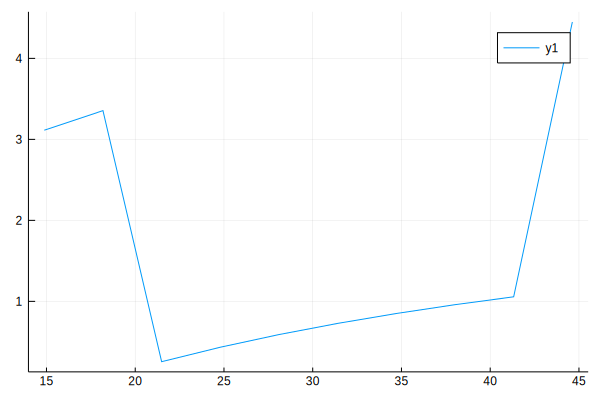

In [229]:
V, C = vfi(V0 ,p, kgrid)
plot(kgrid, C)

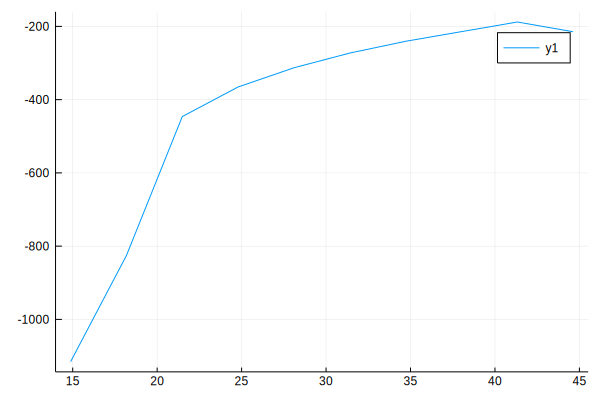

In [230]:
plot(kgrid, V)

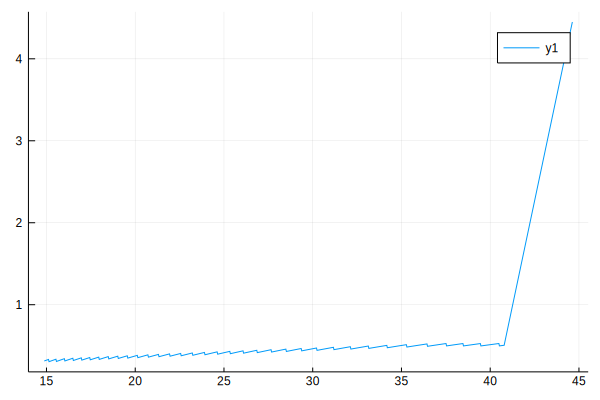

In [232]:
V, C = vfi(V0test, p, ktest)
plot(ktest, C)

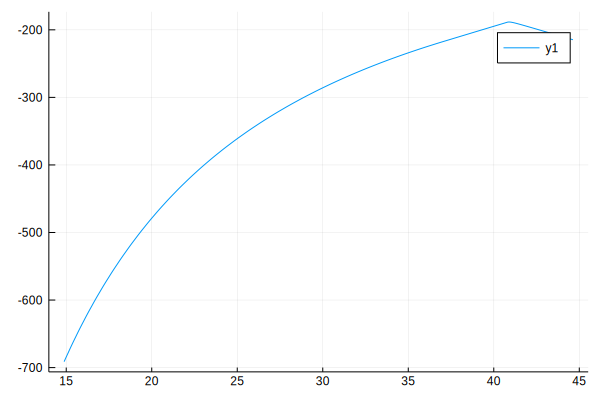

In [233]:
plot(ktest, V)

__Bonus 1: plot a graph showing the convergence back to the steady-state__


__Bonus 2: implement the policy iteration algorithm by adding an evaluation step in the `vfi` function.__
